# map the tercile probabilistic forecasts from the C3S MME 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib

In [3]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr
import dateparser

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt
import palettable

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the downloading of the C3S forecasts 

In [5]:
sys.path.append('../..')

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

/home/nicolasf/mambaforge/envs/ICU_ops/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Parameters for papermill

In [7]:
provider = 'CDS' # should not change
domain_name = 'Water_Watch' # domain name for plotting, see `domains` module
period = "seasonal"
lag = 0 # lag with respect to current month
lead = 1 # lead time (month or season)
quantile = 'tercile' # should stay at "tercile"
varfname = 'tprate' # variable reference in the filenames
varname = 'precip' # variable name in the forecast probabilities
dpath_shapes = '/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles' # shapes for the Pacific countries EEZs
dpath_forecasts = '/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S' # forecast probabilities
fpath = '/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/figures/C3S' # paths for the figures 
fpath_web = '/home/nicolasf/operational/ICU_Web/C3S/' # path for the figures for the web 

### casts the paths to pathlib.Paths 

In [9]:
dpath_shapes = pathlib.Path(dpath_shapes)
dpath_forecasts = pathlib.Path(dpath_forecasts)
fpath = pathlib.Path(fpath)
fpath_web = pathlib.Path(fpath_web)

### domain 

In [10]:
domain = domains.domains[domain_name]

### EEZ shapes 

In [11]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

### year and month (initial month of the forecast)

In [12]:
date = dateparser.parse('today')

In [13]:
date = date - relativedelta(months=lag)

In [14]:
year = date.year 
month = date.month

In [15]:
print(f"{year} - {month}")

2022 - 3


#### list of GCMs to inlude into the MME 

In [16]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC_CanCM4i', 'ECCC_GEM_NEMO']

#### period (`monthly` or `seasonal`)

In [17]:
if period == 'seasonal': 
    nsteps = 3
    first_step = 3
elif period == 'monthly': 
    nsteps = 5
    first_step = 1

In [18]:
step = lead + first_step - 1

In [19]:
step

1

## get the list of files 

In [20]:
lfiles = list(dpath_forecasts.glob(f"{period}_{varfname}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

### checks the files names 

In [21]:
[f.name for f in lfiles]

['monthly_terciles_probabilities_from_2022-03_METEO_FRANCE.netcdf',
 'monthly_terciles_probabilities_from_2022-03_ECCC_CanCM4i.netcdf',
 'monthly_terciles_probabilities_from_2022-03_UKMO.netcdf',
 'monthly_terciles_probabilities_from_2022-03_DWD.netcdf',
 'monthly_terciles_probabilities_from_2022-03_ECMWF.netcdf',
 'monthly_terciles_probabilities_from_2022-03_JMA.netcdf',
 'monthly_terciles_probabilities_from_2022-03_ECCC_GEM_NEMO.netcdf',
 'monthly_terciles_probabilities_from_2022-03_NCEP.netcdf',
 'monthly_terciles_probabilities_from_2022-03_CMCC.netcdf']

### open the multiple files dataset, concatenate along the "GCM" dimension 

In [22]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', combine='nested', engine='netcdf4') 

In [23]:
probs

,Array,Chunk
Bytes,10.09 MiB,1.12 MiB
Shape,"(9, 3, 1, 5, 81, 121)","(1, 3, 1, 5, 81, 121)"
Count,27 Tasks,9 Chunks
Type,float64,numpy.ndarray


### interpolate (for smoother maps)

In [24]:
probs = utils.interp(probs, interp_factor=6)

In [1]:
probs 

NameError: name 'probs' is not defined

In [25]:
probs = probs.mean('GCM')

In [26]:
probs

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 1, step: 5, lat: 486, lon: 726)
Coordinates:
  * time     (time) datetime64[ns] 2022-03-01
  * step     (step) int64 1 2 3 4 5
    month    int64 3
  * tercile  (tercile) int64 1 2 3
  * lon      (lon) float64 120.0 120.2 120.3 120.5 ... 239.5 239.7 239.8 240.0
  * lat      (lat) float64 -50.0 -49.84 -49.67 -49.51 ... 29.51 29.67 29.84 30.0
Data variables:
    precip   (tercile, time, step, lat, lon) float64 dask.array<chunksize=(3, 1, 5, 486, 726), meta=np.ndarray>

### make sure the probabilities sum to 100 over the decile dimension 

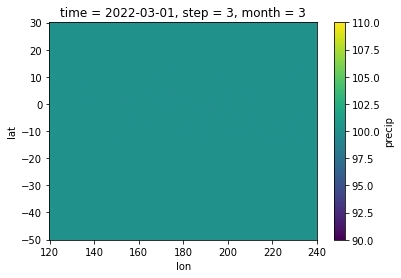

In [27]:
probs.sum(quantile).squeeze().sel(step=3)['precip'].plot()

In [28]:
probs

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 1, step: 5, lat: 486, lon: 726)
Coordinates:
  * time     (time) datetime64[ns] 2022-03-01
  * step     (step) int64 1 2 3 4 5
    month    int64 3
  * tercile  (tercile) int64 1 2 3
  * lon      (lon) float64 120.0 120.2 120.3 120.5 ... 239.5 239.7 239.8 240.0
  * lat      (lat) float64 -50.0 -49.84 -49.67 -49.51 ... 29.51 29.67 29.84 30.0
Data variables:
    precip   (tercile, time, step, lat, lon) float64 dask.array<chunksize=(3, 1, 5, 486, 726), meta=np.ndarray>

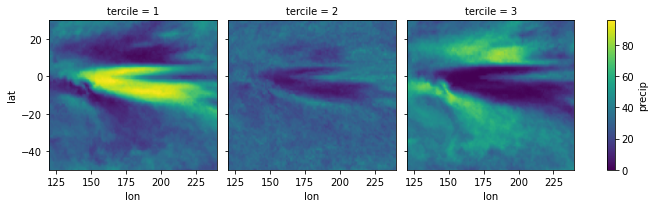

In [29]:
probs.sel(step=3).squeeze()['precip'].plot(col=quantile)

In [30]:
probs = geo.make_mask_from_gpd(probs, merged_EEZs, subset=False, mask_name='mask')

In [31]:
probs

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 1, step: 5, lat: 486, lon: 726)
Coordinates:
  * time     (time) datetime64[ns] 2022-03-01
  * step     (step) int64 1 2 3 4 5
    month    int64 3
  * tercile  (tercile) int64 1 2 3
  * lon      (lon) float64 120.0 120.2 120.3 120.5 ... 239.5 239.7 239.8 240.0
  * lat      (lat) float64 -50.0 -49.84 -49.67 -49.51 ... 29.51 29.67 29.84 30.0
Data variables:
    precip   (tercile, time, step, lat, lon) float64 dask.array<chunksize=(3, 1, 5, 486, 726), meta=np.ndarray>
    mask     (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [32]:
thresholds = [0, 10, 20, 40, 50, 60, 70, 100.0]

In [33]:
hexes = ['#1549b0','#62a3bf','#ffffff','#f5e464','#e39f39','#ff1212','#7d0f05']

In [34]:
cmap = matplotlib.colors.ListedColormap(hexes, name='probabilities')

In [35]:
month_name = list(month_name) + list(month_name)[1:]

### choose the step for the forecast here 

In [36]:
if period == 'monthly': 
    label_period = month_name[month + step]
elif period == 'seasonal': 
    label_period = month_name[month + step - 2] + " - " + month_name[month + step]

In [37]:
dset = probs[varname] * probs['mask']

In [38]:
dset = dset.to_dataset(name=varname)

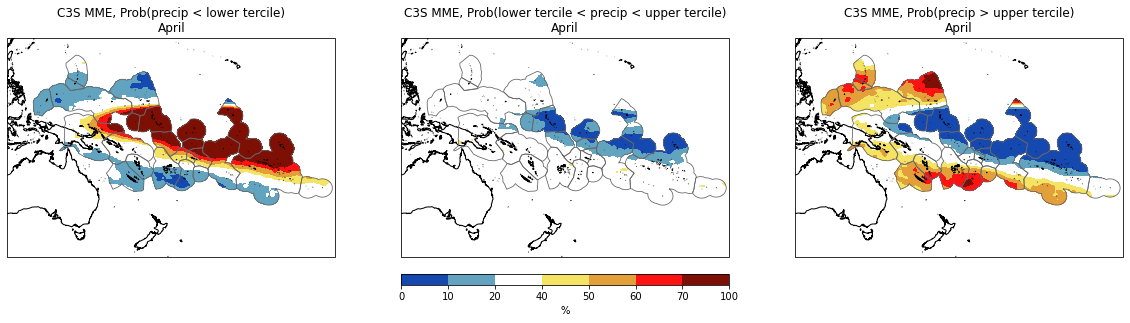

In [39]:
f, axes = plt.subplots(ncols=3, figsize=(20,8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

ax = axes[0]
ax.coastlines(resolution='10m')
im1 = dset[varname].sel(step=step, tercile=1).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title(f"C3S MME, Prob({varname} < lower tercile)\n{label_period}")
plot.add_geom(ax, geoms=EEZs)

ax = axes[1]
ax.coastlines(resolution='10m')
im2 = dset[varname].sel(step=step, tercile=2).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title(f"C3S MME, Prob(lower tercile < {varname} < upper tercile)\n{label_period}")
plot.add_geom(ax, geoms=EEZs)

cbar_ax = ax.axes.inset_axes([0, -0.125, 1, 0.05])

cb = plt.colorbar(im2, cax=cbar_ax, orientation='horizontal')

cb.set_label("%")

ax = axes[2]
ax.coastlines(resolution='10m')
im3 = dset[varname].sel(step=step, tercile=3).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False, title='')
ax.set_title(f"C3S MME, Prob({varname} > upper tercile)\n{label_period}")
plot.add_geom(ax, geoms=EEZs)

f.savefig(fpath.joinpath(f'C3S_MME_{period}_{varname}_{quantile}_{year}_{month:02d}_init_{label_period.replace(" - ","_")}.png'), dpi=200, bbox_inches='tight', facecolor='w')
f.savefig(fpath_web.joinpath(f'C3S_MME_{period}_{varname}_{quantile}_lead{lead}_latest.png'), dpi=200, bbox_inches='tight', facecolor='w')

In [40]:
probs_t = probs[[varname]]

In [41]:
probs_t = probs_t.idxmax(dim='tercile')

In [42]:
probs_t = probs_t.squeeze()

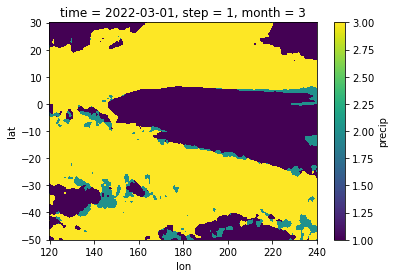

In [43]:
probs_t.sel(step=step)[varname].plot()

In [44]:
probs['category'] = probs_t[varname]

In [45]:
probs

<xarray.Dataset>
Dimensions:   (tercile: 3, time: 1, step: 5, lat: 486, lon: 726)
Coordinates:
  * time      (time) datetime64[ns] 2022-03-01
  * step      (step) int64 1 2 3 4 5
    month     int64 3
  * tercile   (tercile) int64 1 2 3
  * lon       (lon) float64 120.0 120.2 120.3 120.5 ... 239.5 239.7 239.8 240.0
  * lat       (lat) float64 -50.0 -49.84 -49.67 -49.51 ... 29.67 29.84 30.0
Data variables:
    precip    (tercile, time, step, lat, lon) float64 dask.array<chunksize=(3, 1, 5, 486, 726), meta=np.ndarray>
    mask      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    category  (step, lat, lon) float64 dask.array<chunksize=(5, 486, 726), meta=np.ndarray>

In [46]:
cmap_1 = plt.cm.Oranges

In [47]:
cmap_2 = plt.cm.gray_r

In [48]:
cmap_3 = plt.cm.Greens

In [49]:
ticks = np.arange(40,110,10)

In [50]:
probs['category'] = probs['category'] * probs['mask']

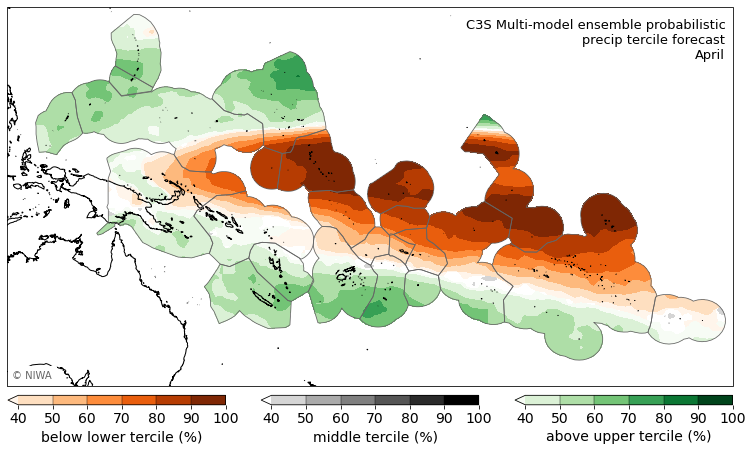

In [51]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(13,8))

im1 = probs.where(probs['category'] == 1).squeeze().sel(tercile=1,step=step)['precip'].plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_1, add_colorbar=False, transform=ccrs.PlateCarree())

cbar_ax_1 = ax.axes.inset_axes([0.001, -0.05, 0.3, 0.025])

cbar_kwargs={'shrink':0.5, 'pad':0.01, 'extend':'both', 'drawedges':True, 'ticks':np.arange(40,110,10), 'aspect':15, 'orientation':'horizontal'}

cb1 = plt.colorbar(im1, cax=cbar_ax_1, **cbar_kwargs)

cb1.set_ticklabels(ticks)

cb1.ax.tick_params(labelsize=14)

cb1.set_label("below lower tercile (%)", fontsize=14)

im2 = probs.where(probs['category'] == 2).squeeze().sel(tercile=2, step=step)['precip'].plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_2, add_colorbar=False, transform=ccrs.PlateCarree())

cbar_ax_2 = ax.axes.inset_axes([0.35, -0.05, 0.3, 0.025], )

cb2 = plt.colorbar(im2, cax=cbar_ax_2, **cbar_kwargs)

cb2.set_ticklabels(ticks)

cb2.ax.tick_params(labelsize=14)

cb2.set_label("middle tercile (%)", fontsize=14)

im3 = probs.where(probs['category'] == 3).squeeze().sel(tercile=3,step=step)['precip'].plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_3, add_colorbar=False, transform=ccrs.PlateCarree())

cbar_ax_3 = ax.axes.inset_axes([0.7, -0.05, 0.3, 0.025], )

cb3 = plt.colorbar(im3, cax=cbar_ax_3, **cbar_kwargs)

cb3.set_ticklabels(ticks)

cb3.ax.tick_params(labelsize=14)

cb3.set_label("above upper tercile (%)", fontsize=14)

ax.coastlines(resolution='10m')

plot.add_geom(ax, geoms=EEZs)

ax.set_title("")

title = f"C3S Multi-model ensemble probabilistic\n{varname} tercile forecast\n{label_period}"

ax.text(0.99, 0.97, title, fontsize=13, fontdict={'color':'k'}, bbox=dict(facecolor='w', edgecolor='w'), horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

# ax.set_extent()

ax.text(0.0065, 0.02, u'\u00A9'+" NIWA", transform=ax.transAxes, bbox=dict(facecolor='w', edgecolor='w'), fontdict=dict(color='0.4'))

# plot.insert_logo(logo_path='../../ICU_Water_Watch/logo/',ax=ax)

ax.set_extent(domain, crs = ccrs.PlateCarree())

### save figures to disk 

In [52]:
f.savefig(fpath.joinpath(f'C3S_MME_most_likely_category_{period}_{varname}_{quantile}_{year}_{month:02d}_init_{label_period.replace(" - ","_")}.png'), dpi=200, bbox_inches='tight', facecolor='w')
f.savefig(fpath_web.joinpath(f'C3S_MME_most_likely_category_{period}_{varname}_{quantile}_lead{lead}_latest.png'), dpi=200, bbox_inches='tight', facecolor='w')

### list the files and get the number of ensemble members 

In [54]:
dpath  = pathlib.Path('/media/nicolasf/END19101/ICU/data/CDS/operational/forecasts/')

In [55]:
lfiles = list(dpath.rglob(f"*from_{year}_{month}_*.netcdf"))

In [56]:
nmembers = []
for fname in lfiles: 
    dset = xr.open_dataset(fname)
    nmembers.append(dset.dims['number'])

In [57]:
print(f"The forecasts from {year} - {month} contain {np.array(nmembers).sum()} members")

The forecasts from 2022 - 3 contain 0.0 members


In [58]:
domain

[125, 240, -35, 25]

In [59]:
probs

<xarray.Dataset>
Dimensions:   (tercile: 3, time: 1, step: 5, lat: 486, lon: 726)
Coordinates:
  * time      (time) datetime64[ns] 2022-03-01
  * step      (step) int64 1 2 3 4 5
    month     int64 3
  * tercile   (tercile) int64 1 2 3
  * lon       (lon) float64 120.0 120.2 120.3 120.5 ... 239.5 239.7 239.8 240.0
  * lat       (lat) float64 -50.0 -49.84 -49.67 -49.51 ... 29.67 29.84 30.0
Data variables:
    precip    (tercile, time, step, lat, lon) float64 dask.array<chunksize=(3, 1, 5, 486, 726), meta=np.ndarray>
    mask      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    category  (step, lat, lon) float64 dask.array<chunksize=(5, 486, 726), meta=np.ndarray>

In [60]:
country_name = 'Fiji'

In [61]:
coastlines = geo.get_coastlines(dpath_shapes='/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/')

In [62]:
for country_name in coastlines.country_na: 
    
    print(f"   --> processing {country_name} for the SPI\n")
    
    coastline = coastlines.query(f"country_na == '{country_name}'")
    
    EEZ = EEZs.query(f"COUNTRYNAM == '{country_name}'")
    
    subset_probs = geo.make_mask_from_gpd(probs, EEZ, subset=True, mask_name='EEZ')
    
    dataarray = subset_probs[varname] * subset_probs['EEZ']
    
    lon_min = np.floor(subset_probs.lon.data.min())
    lon_max = np.ceil(subset_probs.lon.data.max())
    lat_min = np.floor(subset_probs.lat.data.min())
    lat_max = np.ceil(subset_probs.lat.data.max())

    # make xlocs and ylocs 

    xlocs = np.linspace(lon_min, lon_max + 1, 5, endpoint=True)
    ylocs = np.linspace(lat_min, lat_max + 1, 5, endpoint=True)

    xlocs[xlocs > 180] -= 360 # fix the longitudes to go from -180 to 180 (for plotting)
    
    data = subset_probs[[varname]] * subset_probs['EEZ']
    
    f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(13,8))

    im1 = data.where(probs['category'] == 1).squeeze().sel(tercile=1, step=step)[varname].\
    plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_1, add_colorbar=False, transform=ccrs.PlateCarree())

    # cbar_ax_1 = ax.axes.inset_axes([0.001, -0.05, 0.3, 0.025])

    cbar_ax_1 = ax.axes.inset_axes([1.1, 0, 0.025, 0.3])

    cbar_kwargs={'shrink':0.5, 'pad':0.01, 'extend':'both', 'drawedges':True, 'ticks':np.arange(40,110,10), 'aspect':15, 'orientation':'vertical'}

    cb1 = plt.colorbar(im1, cax=cbar_ax_1, **cbar_kwargs)

    cb1.set_ticklabels(ticks)

    cb1.ax.tick_params(labelsize=10)

    cb1.set_label("below lower tercile (%)", fontsize=12)

    im2 = data.where(probs['category'] == 2).squeeze().sel(tercile=2, step=step)[varname].\
    plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_2, add_colorbar=False, transform=ccrs.PlateCarree())

    cbar_ax_2 = ax.axes.inset_axes([1.1, 0.35, 0.025, 0.3])

    cb2 = plt.colorbar(im2, cax=cbar_ax_2, **cbar_kwargs)

    cb2.set_ticklabels(ticks)

    cb2.ax.tick_params(labelsize=10)

    cb2.set_label("middle tercile (%)", fontsize=12)

    im3 = data.where(probs['category'] == 3).squeeze().sel(tercile=3,step=step)[varname].plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_3, add_colorbar=False, transform=ccrs.PlateCarree())

    cbar_ax_3 = ax.axes.inset_axes([1.1, 0.7, 0.025, 0.3])

    cb3 = plt.colorbar(im3, cax=cbar_ax_3, **cbar_kwargs)

    cb3.set_ticklabels(ticks)

    cb3.ax.tick_params(labelsize=10)

    cb3.set_label("above upper tercile (%)", fontsize=12)

    # ax.coastlines(resolution='10m')

    plot.add_geom(ax=ax, geoms=EEZ)

    title = f"C3S MME probabilistic\n{varname} {quantile} forecast\n{label_period}"

    ax.set_title(title)

    ax.text(0.95, 0.95, f"{country_name}", transform=ax.transAxes, fontsize=15, fontdict={'color':'k'}, bbox=dict(facecolor='w', edgecolor='w'), horizontalalignment='right', verticalalignment='center')

    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    gl = ax.gridlines(draw_labels=True, linestyle=':', xlocs=xlocs, ylocs=ylocs, crs=ccrs.PlateCarree())

    gl.top_labels = False
    gl.right_labels = False

    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    coastlines.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=1, color='0.4')
    coastline.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=1, color='k')
    
    fpath_country = fpath.joinpath(utils.sanitize_name(country_name))
    
    if not(fpath_country.exists()): 
        
        fpath_country.mkdir(parents=True)
    
    f.savefig(fpath_country.joinpath(f'{utils.sanitize_name(country_name)}_C3S_MME_most_likely_category_{period}_{varname}_{quantile}_{year}_{month:02d}_init_{label_period.replace(" - ","_")}.png'), dpi=200, bbox_inches='tight', facecolor='w')
    
    fpath_country = fpath_web.joinpath(utils.sanitize_name(country_name))
    
    if not(fpath_country.exists()): 
        
        fpath_country.mkdir(parents=True)
    
    f.savefig(fpath_country.joinpath(f'{utils.sanitize_name(country_name)}_C3S_MME_most_likely_category_{period}_{varname}_{quantile}_lead{lead}_latest.png'), dpi=200, bbox_inches='tight', facecolor='w')
    
    plt.close(f)

   --> processing American Samoa for the SPI

   --> processing Cook Islands for the SPI

   --> processing Federated States of Micronesia for the SPI

   --> processing Fiji for the SPI

   --> processing French Polynesia for the SPI

   --> processing Guam for the SPI

   --> processing Kiribati: Gilbert Islands for the SPI

   --> processing Kiribati: Line Islands for the SPI

   --> processing Kiribati: Phoenix Islands for the SPI

   --> processing Marshall Islands for the SPI

   --> processing Nauru for the SPI

   --> processing New Caledonia for the SPI

   --> processing Niue for the SPI

   --> processing Northern Marianas for the SPI

   --> processing Palau for the SPI

   --> processing Papua New Guinea for the SPI

   --> processing Pitcairn Islands for the SPI

   --> processing Samoa for the SPI

   --> processing Solomon Islands for the SPI

   --> processing Tokelau for the SPI

   --> processing Tonga for the SPI

   --> processing Tuvalu for the SPI

   --> process